In [239]:
# importing helper libraries
import numpy as np
import pandas as pd
# import machine learning libraries
import tensorflow as tf
from tensorflow import keras
# Importing data preprocessing techniques
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data Reading, Downloaded from Yahoo Finance

In [240]:
data = pd.read_csv("../BTC-USD.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [241]:
data.isna().astype("int").sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [242]:
# we need to remove null or NaN value from our dataset
data.dropna(inplace = True)
data.isna().astype("int").sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [243]:
required_data = data[["High", "Low", "Close"]]
required_data.head()

,High,Low,Close
0,468.174011,452.421997,457.334015
1,456.859985,413.104004,424.440002
2,427.834991,384.532013,394.795990
3,423.295990,389.882996,408.903992
4,412.425995,393.181000,398.821014


# Data Preprocessing

Use the data before 3/19/2024 for training, and 3/19/2024 to 5/19/2024 for testing

In [244]:
idx_split = data[data.Date == "2024-03-19"].index[0]
idx_split

3471

In [245]:
# train_data_length = int(0.9 * len(required_data))
train_data_length = idx_split
print(f"training data fraction : {train_data_length/len(required_data)}")

training data fraction : 0.9827293318233296


In [246]:
# Before we normalize the data, we need to split the data into train and test split, so that data snooping can be
# avoided

train_data = required_data.iloc[:train_data_length]
test_data = required_data.iloc[train_data_length:]

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (3471, 3)
Testing data : (61, 3)


In [247]:
# Data Normalization
# This will scale the data between -1 and 1
normalizer = MinMaxScaler(feature_range = (-1, 1))
# Fit the normalizer on the train data only
normalizer.fit(train_data)

# converting the train data
train_data = normalizer.transform(train_data)
test_data  = normalizer.transform(test_data)

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (3471, 3)
Testing data : (61, 3)


In [248]:
# checking the range of train data and test data
print(f"Maximum and minimum value of training data : {np.max(train_data), np.min(train_data)}")
print(f"Maximum and minimum value of testing  data : {np.max(test_data), np.min(test_data)}")

Maximum and minimum value of training data : (1.0, -1.0)
Maximum and minimum value of testing  data : (0.971859279181212, 0.5846468747711364)


In [249]:
# this piece of code creates the data where features and targets are multivariate

def create_window_split_with_target_multivariate(data, window_size, horizon=1, stride=1):
    """
    Function to split a multivariate time series data into overlapping windows and generate target variables.
    
    Parameters:
        data (numpy.ndarray): The input multivariate time series data with shape (num_samples, num_features).
        window_size (int): Size of each window.
        horizon (int): Forecast horizon, i.e., number of future time steps to predict. Default is 1.
        stride (int): The stride or step size between consecutive windows. Default is 1.
    
    Returns:
        numpy.ndarray, numpy.ndarray: Arrays containing the split windows and corresponding target variables.
    """
    num_samples = len(data)
    num_features = data.shape[1]
    num_windows = (num_samples - window_size - horizon) // stride + 1
    windows = np.zeros((num_windows, window_size, num_features))
    targets = np.zeros((num_windows, num_features))
    
    for i in range(num_windows):
        start_index = i * stride
        end_index = start_index + window_size
        windows[i] = data[start_index:end_index]
        targets[i] = data[end_index + horizon - 1]  # Assuming the target is the value at the end of the forecast horizon
    
    return windows, targets


window_size = 15
horizon = 1
stride = 1

train_features, train_lables = create_window_split_with_target_multivariate(train_data, window_size, horizon, stride)
test_features, test_lables = create_window_split_with_target_multivariate(test_data, window_size, horizon, stride)


print(f"Training Data : {train_features.shape, train_lables.shape}")
print(f"Testing Data : {test_features.shape, test_lables.shape}")

Training Data : ((3456, 15, 3), (3456, 3))
Testing Data : ((46, 15, 3), (46, 3))


# Model Training and Evaluation

## GRU Models

Model 1: This model has 2 GRU layers with 128 units each and Group Normalization

In [250]:
from tensorflow.keras.layers import GRU

def make_gru128():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape = (15, 3)),
            GRU(units = 128, activation = "gelu", return_sequences = True),
            keras.layers.GroupNormalization(),
            GRU(units = 128, activation = "gelu"),
            keras.layers.GroupNormalization(),
            keras.layers.Dense(units=64, activation="gelu"),
            keras.layers.Dense(units=3, activation="tanh")  
        ],
    )
gru128 = make_gru128()
gru128.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_36 (GRU)                    │ (None, 15, 128)        │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_42          │ (None, 15, 128)        │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_37 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_43          │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,107 (621.51 KB)

 Trainable params: 159,107 (621.51 KB)

 Non-trainable params: 0 (0.00 B)

In [251]:
def make_gru128b():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape = (15, 3)),
            keras.layers.Bidirectional(GRU(units=128, activation="gelu", return_sequences=True)),
            keras.layers.GroupNormalization(),
            keras.layers.Bidirectional(GRU(units=128, activation="gelu")),
            keras.layers.GroupNormalization(),
            keras.layers.Dense(units=64, activation="gelu"),
            keras.layers.Dense(units=3, activation="tanh")  
        ]
    )
gru128b = make_gru128b()
gru128.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_36 (GRU)                    │ (None, 15, 128)        │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_42          │ (None, 15, 128)        │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_37 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_43          │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,107 (621.51 KB)

 Trainable params: 159,107 (621.51 KB)

 Non-trainable params: 0 (0.00 B)

detect if the model has converge early

Model 2: This model has 2 GRU layers with 32 units each and Layer Normalization

In [252]:
def make_gru32():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape=(15, 3)),
            GRU(units=32, activation="tanh", return_sequences=True),
            keras.layers.LayerNormalization(),
            GRU(units=32, activation="tanh"),
            keras.layers.LayerNormalization(),
            keras.layers.Dense(units=32, activation="tanh"),
            keras.layers.Dense(units=3)  
        ]
    )
gru32 = make_gru32()
gru32.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_40 (GRU)                    │ (None, 15, 32)         │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_18          │ (None, 15, 32)         │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_41 (GRU)                    │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_19          │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171 (43.64 KB)

 Trainable params: 11,171 (43.64 KB)

 Non-trainable params: 0 (0.00 B)

In [253]:
def make_gru32b():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape=(15, 3)),
            keras.layers.Bidirectional(GRU(units=32, activation="tanh", return_sequences=True)),
            keras.layers.LayerNormalization(),
            keras.layers.Bidirectional(GRU(units=32, activation="tanh")),
            keras.layers.LayerNormalization(),
            keras.layers.Dense(units=32, activation="tanh"),
            keras.layers.Dense(units=3)  
        ]
    )
gru32b = make_gru32b()
gru32b.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_22                │ (None, 15, 64)         │         7,104 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_20          │ (None, 15, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 64)             │        18,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_21          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.76 KB)

 Trainable params: 28,355 (110.76 KB)

 Non-trainable params: 0 (0.00 B)

Model 3: RNN Model

In [254]:
def make_rnn128():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape=(15, 3)),
            keras.layers.RNN(
                keras.layers.SimpleRNNCell(units=128, activation="gelu"),
                return_sequences=True
            ),
            keras.layers.GroupNormalization(),
            keras.layers.RNN(
                keras.layers.SimpleRNNCell(units=128, activation="gelu"),
            ),
            keras.layers.GroupNormalization(),
            keras.layers.Dense(units=64, activation="gelu"),
            keras.layers.Dense(units=3, activation="tanh")
        ]
    )
rnn128 = make_rnn128()
rnn128.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_24 (RNN)                    │ (None, 15, 128)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_46          │ (None, 15, 128)        │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_25 (RNN)                    │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_47          │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,755 (229.51 KB)

 Trainable params: 58,755 (229.51 KB)

 Non-trainable params: 0 (0.00 B)

In [283]:
def make_rnn32():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape=(15, 3)),
            keras.layers.RNN(
                keras.layers.SimpleRNNCell(units=64, activation="tanh"),
                return_sequences=True
            ),
            keras.layers.GroupNormalization(),
            keras.layers.RNN(
                keras.layers.SimpleRNNCell(units=64, activation="tanh"),
            ),
            keras.layers.GroupNormalization(),
            keras.layers.Dense(units=64, activation="tanh"),
            keras.layers.Dense(units=3, activation="tanh")
        ]
    )
rnn32 = make_rnn32()
rnn32.summary()

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_38 (RNN)                    │ (None, 15, 64)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_60          │ (None, 15, 64)         │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_39 (RNN)                    │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_61          │ (None, 64)             │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,219 (67.26 KB)

 Trainable params: 17,219 (67.26 KB)

 Non-trainable params: 0 (0.00 B)

In [284]:
callbacks = []
early_stops = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)
callbacks.append(early_stops)

get model initializers in case we need to retrain the models

In [285]:
model_initalizers = dict([(key.replace("make_", ""), value) for key, value in locals().items() if key.startswith("make")])
model_initalizers

{'gru128': <function __main__.make_gru128()>,
 'gru128b': <function __main__.make_gru128b()>,
 'gru32': <function __main__.make_gru32()>,
 'gru32b': <function __main__.make_gru32b()>,
 'rnn128': <function __main__.make_rnn128()>,
 'rnn32': <function __main__.make_rnn32()>}

In [286]:
models = dict([(key, value) for key, value in locals().items() if value.__class__ == keras.Sequential and not key.startswith("_")])
models

{'gru128': <Sequential name=sequential_29, built=True>,
 'gru32': <Sequential name=sequential_31, built=True>,
 'gru32b': <Sequential name=sequential_32, built=True>,
 'gru128b': <Sequential name=sequential_30, built=True>,
 'rnn32': <Sequential name=sequential_40, built=True>,
 'rnn128': <Sequential name=sequential_33, built=True>,
 'model': <Sequential name=sequential_33, built=True>}

train all models

In [287]:
histories = {}
for name, model in models.items():
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate = 0.001, clipnorm=1.), loss = "mse", metrics = ["mse", "mae"])
    history = model.fit(train_features, train_lables, epochs=100, validation_split=0.1, callbacks=callbacks + [tf.keras.callbacks.ModelCheckpoint(f"{name}.keras", save_best_only=True)])
    histories[name] = history

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 7.5911e-04 - mae: 0.0174 - mse: 7.5911e-04 - val_loss: 0.0025 - val_mae: 0.0360 - val_mse: 0.0025
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1259e-04 - mae: 0.0132 - mse: 5.1259e-04 - val_loss: 0.0017 - val_mae: 0.0348 - val_mse: 0.0017
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0495e-04 - mae: 0.0118 - mse: 4.0495e-04 - val_loss: 0.0024 - val_mae: 0.0375 - val_mse: 0.0024
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0752e-04 - mae: 0.0111 - mse: 4.0752e-04 - val_loss: 0.0019 - val_mae: 0.0316 - val_mse: 0.0019
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0333e-04 - mae: 0.0116 - mse: 4.0333e-04 - val_loss: 0.0010 - val_mae: 0.0213 - val_mse: 0.0010
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6756e-04 - mae: 0.0111 - mse: 3.6756e-04 - val_loss: 0.0020 - val_mae: 0.0340 - val_mse: 0.0020
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 

uncomment to retrain some of the models

In [282]:
# to_retrain = {"rnn32"}
# for name in to_retrain:
#     models[name] = model_initalizers[name]()
#     # reinitialize the model
#     models[name].compile(optimizer=keras.optimizers.AdamW(learning_rate = 0.001, clipvalue=.5), loss = "mse", metrics = ["mse", "mae"])
#     history = models[name].fit(train_features, train_lables, epochs=100, validation_split=0.1, callbacks=callbacks + [tf.keras.callbacks.ModelCheckpoint(f"{name}.keras", save_best_only=True)])
#     histories[name] = history

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4032 - mae: 0.5681 - mse: 0.4032 - val_loss: 0.4484 - val_mae: 0.5994 - val_mse: 0.4484
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2072 - mae: 0.3580 - mse: 0.2072 - val_loss: 0.4657 - val_mae: 0.6147 - val_mse: 0.4657
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1954 - mae: 0.3443 - mse: 0.1954 - val_loss: 0.4505 - val_mae: 0.6022 - val_mse: 0.4505
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1921 - mae: 0.3434 - mse: 0.1921 - val_loss: 0.4713 - val_mae: 0.6193 - val_mse: 0.4713
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1951 - mae: 0.3413 - mse: 0.1951 - val_loss: 0.4438 - val_mae: 0.5967 - val_mse: 0.4438
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2010 - mae: 0.3506 - mse: 0.2010 - val_loss: 0.4704 - val_mae: 0.6186 - val_mse: 0.4704
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1911 - mae: 0.3388 - mse: 0.1911 - val_loss: 

KeyboardInterrupt: 

## Training progress

In [291]:
def model_name_to_linestyle(name):
    if name.startswith("gru"):
        if "b" in name:
            return ":"
        else:
            return "-"
    elif name.startswith("rnn"):
        return "-."
    else:
        return "--"

In [292]:
def plot_training_progress(histories):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for name, history in histories.items():
        history = histories[name]
        train_loss = history.history["loss"]
        valid_loss = history.history["val_loss"]
        
        train_mae = history.history["mae"]
        valid_mae = history.history["val_mae"]
    
        axes[0].plot(range(len(valid_loss)), valid_loss, label=name, linestyle=model_name_to_linestyle(name))
        axes[1].plot(range(len(valid_mae)),  valid_mae,  label=name, linestyle=model_name_to_linestyle(name))
        axes[2].plot(range(len(train_loss)), train_loss, label=name, linestyle=model_name_to_linestyle(name))    
        axes[3].plot(range(len(train_mae)),  train_mae,  label=name, linestyle=model_name_to_linestyle(name))
    axes[0].set_title("Validation MSE vs Epochs")
    axes[1].set_title("Validation MAE vs Epochs")
    axes[2].set_title("Training MSE vs Epochs")
    axes[3].set_title("Training MAE vs Epochs")
    axes[0].set_ylabel("Loss value")
    for ax in axes:
        ax.set_xlabel("Epoch") 
        ax.set_yscale("log")
    axes[0].legend()
    plt.show()

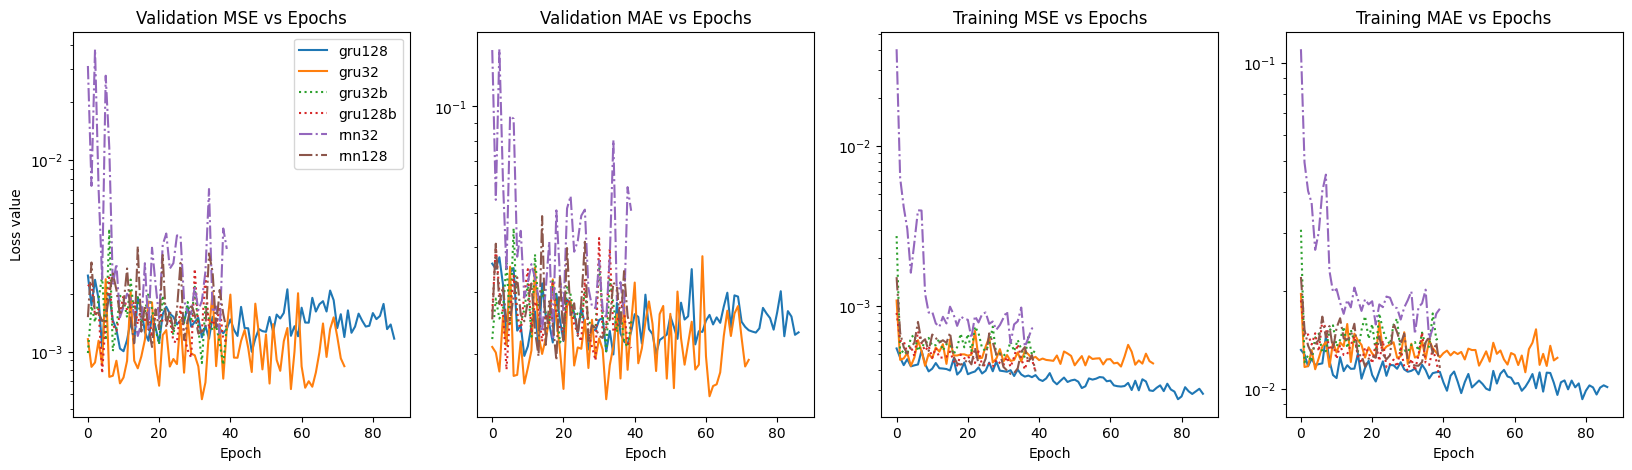

In [301]:
plot_training_progress(histories)

In [294]:
import matplotlib.pyplot as plt

In [302]:
def plot(models):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # true values
    axes[0].plot(test_lables[:, 0], label = "True")
    axes[1].plot(test_lables[:, 1], label = "True")
    axes[2].plot(test_lables[:, 2], label = "True")
    for name, model in models.items():
        test_predicts = model.predict(test_features)
        
        axes[0].plot(test_predicts[:, 0], label=name, linestyle=model_name_to_linestyle(name))
        axes[0].set_title('High Value')
        axes[0].set_xlabel('Future Dates')
        axes[0].set_ylabel('Predicted values')
        
        axes[1].plot(test_predicts[:, 1], label=name, linestyle=model_name_to_linestyle(name))
        axes[1].set_title('Low Value')
        axes[1].set_xlabel('Future Dates')
        axes[1].set_ylabel('Predicted values')
        
        axes[2].plot(test_predicts[:, 2], label=name, linestyle=model_name_to_linestyle(name))
        axes[2].set_title('Close Value')
        axes[2].set_xlabel('Future Dates')
        axes[2].set_ylabel('Predicted values')
    axes[0].legend()
    # for ax in axes:
    #     ax
    plt.show()

In [297]:
models.pop("model")

<Sequential name=sequential_33, built=True>

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


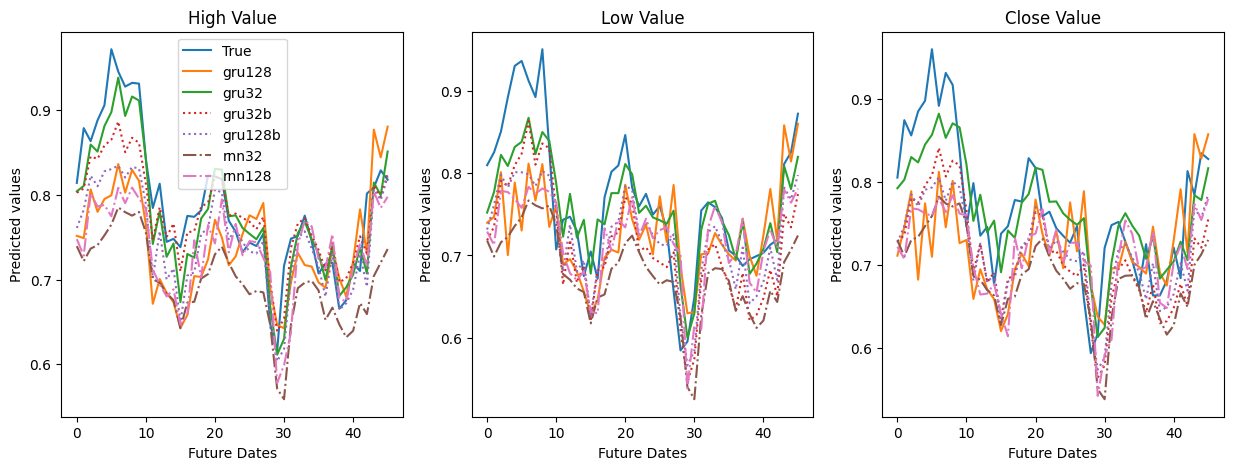

In [303]:
plot(models)

In [266]:
import tensorflow as tf

In [267]:
tf.__version__

'2.16.1'